In [1]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from centrex_tlf import states, couplings, transitions, hamiltonian, lindblad

In [2]:
Ez = smp.symbols("E_z")

In [3]:
X_states_uncoupled = states.generate_uncoupled_states_ground(Js=[0, 1, 2, 3])

In [4]:
ham_uncoupled = hamiltonian.generate_uncoupled_hamiltonian_X(X_states_uncoupled)
ham_func = hamiltonian.generate_uncoupled_hamiltonian_X_function(ham_uncoupled)

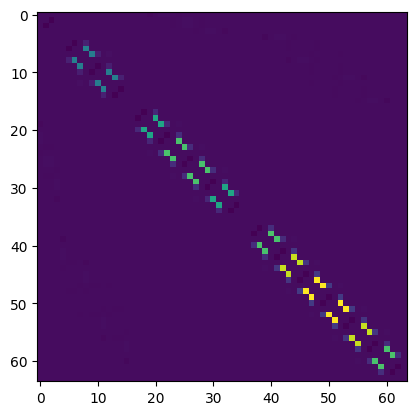

In [5]:
ham = ham_func([0, 0, 0], [0, 0, 1e-5]).real
np.fill_diagonal(ham, 0)
fig, ax = plt.subplots()

ax.imshow(ham)

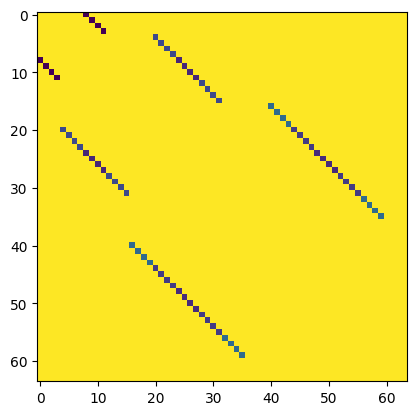

In [6]:
fig, ax = plt.subplots()

ax.imshow(ham_uncoupled.HSz.real)

In [7]:
H0 = ham_func([0, 0, 0], [0, 0, 1e-5])
eigenvals, eigenvecs = np.linalg.eigh(H0)
H0 = np.eye(len(eigenvals)) * eigenvals
HSz = eigenvecs.conj().T @ (ham_uncoupled.HSz) @ eigenvecs

# filter small values
m = np.abs(HSz) < (np.abs(HSz).max() / 1e4)
HSz[m] = 0

# make states and filter
QN = hamiltonian.matrix_to_states(eigenvecs, list(X_states_uncoupled))
QN = [qn.remove_small_components().normalize() for qn in QN]

In [8]:
QN_coupled = [qn.transform_to_coupled() for qn in QN]
QN_coupled = [qn.remove_small_components().normalize() for qn in QN_coupled]

In [9]:
from typing import List


from centrex_tlf.couplings.transition import TransitionSelector


trans = [
    transitions.MicrowaveTransition(0, 1),
    transitions.MicrowaveTransition(1, 2),
]

transition_selectors: List[TransitionSelector] = (
    couplings.generate_transition_selectors(
        transitions=trans,
        polarizations=[
            [couplings.polarization_Z, couplings.polarization_X],
            [couplings.polarization_Z, couplings.polarization_X],
        ],
    )
)

QN_coupled_largest = [qn.largest for qn in QN_coupled]
coupling_fields = []
for trans in transition_selectors:
    ground_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.ground]
        )
    ]
    excited_states = [
        QN_coupled[idx]
        for idx in np.unique(
            [QN_coupled_largest.index(qn.largest) for qn in trans.excited]
        )
    ]

    cf = []
    for pol in trans.polarizations:
        cmat = couplings.generate_coupling_matrix(
            QN_coupled, ground_states, excited_states, pol
        )
        # filter small values
        cmat[np.abs(cmat) < (np.abs(cmat).max() / 1e4)] = 0
        cf.append(couplings.CouplingField(pol, cmat))

    main_coupling = np.abs(cf[0].field).max()
    idg, ide = np.where(np.abs(cf[0].field) == main_coupling)[0]
    coupling_fields.append(
        couplings.CouplingFields(
            QN_coupled[idg],
            QN_coupled[ide],
            main_coupling,
            ground_states,
            excited_states,
            cf,
        )
    )

In [10]:
H_symbolic = lindblad.generate_total_symbolic_hamiltonian(
    QN_coupled, H0, coupling_fields, transition_selectors
)

In [23]:
Ωs = [t.Ω for t in transition_selectors]
Δs = [t.δ for t in transition_selectors]
pols = []
for transition in transition_selectors:
    if not transition.polarization_symbols:
        pols.append(None)
    else:
        pols.append(transition.polarization_symbols)
ham_sym = lindblad.generate_hamiltonian.generate_symbolic_hamiltonian(
    H0, coupling_fields, Ωs, pols
)
T = lindblad.generate_unitary_transformation_matrix(ham_sym)

In [48]:
def strip_unit_floats(expr: smp.Basic) -> smp.Basic:
    """
    Recursively remove any float coefficient ±1.0 from products:
      1.0*A  → A
     -1.0*A  → -A
    Inside Add, Mul, Pow, exp(), sin(), … anything.
    """
    # 1) If it's a product, look for ±1.0
    if expr.is_Mul:
        # find all float args equal to ±1.0
        unit_floats = [
            a for a in expr.args if isinstance(a, smp.Float) and abs(a) == 1.0
        ]
        if unit_floats:
            # compute overall sign from those floats
            sign = 1
            for f in unit_floats:
                if f < 0:
                    sign *= -1
            # keep everything except those ±1.0 floats
            other = [
                a for a in expr.args if not (isinstance(a, smp.Float) and abs(a) == 1.0)
            ]
            # rebuild
            if not other:
                return smp.Integer(sign)  # e.g. expr was just -1.0 or +1.0
            core = smp.Mul(*other)
            return core if sign == 1 else -core

    # 2) Otherwise, recurse into sub-expressions
    if expr.args:
        return expr.func(*[strip_unit_floats(arg) for arg in expr.args])

    # 3) Nothing to do for symbols, Integers, Floats≠±1.0, etc.
    return expr


def clean_matrix_unit_floats(M: smp.Matrix) -> smp.Matrix:
    return M.applyfunc(strip_unit_floats)


In [56]:
def apply_ac_stark_shift(
    M: smp.Matrix, t: smp.Symbol = smp.Symbol("t", real=True)
) -> smp.Matrix:
    """
    For each upper-triangular M[n,m] = amp * exp(±I*t*det),
    shift diag m,m by +amp**2/|det|, diag n,n by -amp**2/|det|,
    and zero both off-diagonals.
    """
    M2 = M.copy()
    for n in range(M2.rows):
        for m in range(n + 1, M2.cols):
            expr = M2[n, m]
            # split off any exp(...) factor
            amp, exp_fac = expr.as_independent(smp.exp)
            if exp_fac.func is not smp.exp:
                continue

            # get the argument of the exp:
            arg = exp_fac.args[0]
            # must look like I*t*det or -I*t*det
            if not (arg.is_Mul and t in arg.args and smp.I in arg.args):
                continue

            # extract det symbol/expression:
            det = arg / (smp.I * t)

            # compute shift
            shift = amp**2 / smp.Abs(det)

            # apply to diagonals
            M2[m, m] += shift
            M2[n, n] -= shift

            # zero out Hermitian pair
            M2[n, m] = 0
            M2[m, n] = 0

    return M2


In [57]:
energies = np.diag(H0)

transformed = smp.Matrix(
    smp.simplify(
        T.adjoint() @ (smp.diag(*np.diag(ham_sym)) + HSz * Ez) @ T
        - 1j * T.adjoint() @ smp.diff(T, smp.Symbol("t", real=True))
    )
)
transformed = clean_matrix_unit_floats(transformed)
transformed_acstark = apply_ac_stark_shift(transformed)

# for idc, (δ, coupling) in enumerate(zip(Δs, coupling_fields)):
#     # generate transition frequency symbol
#     ω = smp.Symbol(f"ω{idc}", real=True)
#     # get indices of ground and excited states
#     idg = QN_coupled.index(coupling.ground_main)
#     ide = QN_coupled.index(coupling.excited_main)

#     # transform to δ instead of ω and E
#     if idg < ide:
#         transformed = transformed.subs(ω, energies[ide] - energies[idg] + δ)
#     elif idg > ide:
#         transformed = transformed.subs(ω, energies[idg] - energies[ide] + δ)

# remove excited state energy from all diagonal entries
# for idc, (δ, coupling) in enumerate(zip(Δs, coupling_fields)):
#     idg = QN_coupled.index(coupling.ground_main)
#     expr = transformed[idg, idg]
#     for d in Δs:
#         expr = expr.subs(d, 0)

#     for idx in range(transformed.shape[0]):
#         transformed[idx, idx] -= expr


In [58]:
transformed_acstark

Matrix([
[E0 - 1510207248289.93*E_z**2/Abs(ω0) + ω0 + ω1,                                              0,                                             0,                                              0,                                                                           0,                                                                           0,                                                                           0,                                                                           0,                                                                           0,                                                                           0,                                                                           0,                                                                            0,                                                                            0,                                                                            0,                           